In [1]:
using Pkg
Pkg.activate("lego-env")

# Only run this the first time:
# Pkg.add("Conda")
# Pkg.add(["Distributions", "ProgressMeter", "Gen", "Plots", "Parameters", "PyCall"])
#Pkg.add(["Images", "FileIO", "ColorTypes", "FixedPointNumbers", "ImageMagick"])

using FileIO, Images, ColorTypes, FixedPointNumbers  
using Statistics

using Distributions
using ProgressMeter
using Gen, Plots 
using Parameters
using PyCall
np = pyimport("numpy");

  Activating project at `/nfs/roberts/project/psyc2610/psyc2610_bff9/lego-gen/lego-env`


In [2]:
# CONFIG
FIXED_GLOBAL_POS = [0.0, -1.0, 0] # scene floor is at Y=-1
FIXED_GLOBAL_ROT_Y = 0.0  # global y rotation
FIXED_GLOBAL_SCALE = 0.03 

# rendering parameters
SPP_VAL = 64     # used for rendering
IMAGE_SIZE = 128  # used for rendering
WIDTH_VAL = 8
DEPTH_VAL = 8
MAX_HEIGHT_VAL = 12
# ================================================

# Output params
OUTPUT_IMG_SIZE = 256  # used to display traces
TRACE_STEP = 2 # trace steps for gifs
OUTPUT_SPP = 128
N_CHAINS = 5 # number of cains for expectation-variance plot
# ================================================

# Number of iterations:
MH_ITERS = 600               # Metropolis-hastings iterations
LAYER_ITERS = 150        # How many MCMC steps to run at each z-level

# Output directory
OUTPUT_DIR = "outputs"
mkpath(OUTPUT_DIR)
for s in ["mh", "layer_one_view", "layer_two_view", "targets"]
    mkpath(joinpath(OUTPUT_DIR, s))
end;

In [3]:
include("src/BrickVocabulary.jl")
include("src/LegoFunctions.jl")
include("src/LegoStructures.jl")
include("src/PostProcessing.jl");

In [4]:
mi = pyimport("mitsuba")
#mi.set_variant("scalar_rgb") # using cpu
mi.set_variant("cuda_ad_rgb") # using gpu
@pyinclude("./src/scene_setup.py") 

### Generate vocabulary and ground truth figures

Rendering Vocabulary Showcase (Scale: 0.045)...
Saved Vocabulary Plot: outputs/brick_vocabulary.png


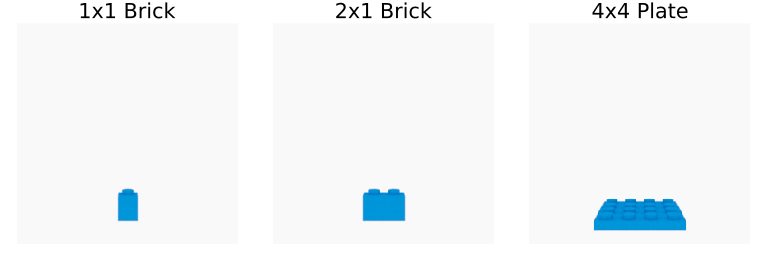

In [5]:
# Plot brick vocabulary
plot_vocabulary()

In [6]:
# save ground truth structures
(obs_image_map, obs_bitmap, num_bricks, struct_name) = generate_table_ground_truth(spp=128, img_size=512) 
save_ground_truth_img(obs_bitmap, "targets/table")

(obs_image_map, obs_bitmap, num_bricks, struct_name) = generate_pyramid_ground_truth(spp=128, img_size=512) 
save_ground_truth_img(obs_bitmap, "targets/pyramid")

Generating 'Tall Table' ground truth (Two Views: false)...
Saved Ground Truth Image: outputs/targets/table.png
Generating 'Pyramid' ground truth (Two Views: false)...
Saved Ground Truth Image: outputs/targets/pyramid.png


### Pick target (table or pyramid):

In [15]:
# select either as a target structure
(obs_image_map, obs_bitmap, num_bricks, struct_name) = generate_table_ground_truth()  
#(obs_image_map, obs_bitmap, num_bricks, struct_name) = generate_pyramid_ground_truth()


# set poisson mean as the true number of bricks:
#lambda_val = 3    # poisson lambda set here (or use the true number from the generation below)
lambda_val = num_bricks

obs_bitmap

Generating 'Tall Table' ground truth (Two Views: false)...


PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

# Metropolis-Hasting

In [16]:
# naive approch: metropolis-hasting

# make an initial trace with no bricks
constraints = Gen.choicemap()
constraints[:num_bricks] = 0 

# merge constraints with observation
combined_choices = merge(obs_image_map, constraints) 

# make the initial trace
(trace, _) = Gen.generate(lego_structure_model, (lambda_val, WIDTH_VAL, DEPTH_VAL, MAX_HEIGHT_VAL, IMAGE_SIZE), combined_choices)
println("Initial trace score: $(get_score(trace))")

# mcmc loop
traces_mh = []
push!(traces_mh, trace)
for iter in 1:MH_ITERS

    # Kernel 1: Add/Remove bricks
    #    Proposes adding or removing a brick from the scene: adding a random brick or removing last brick
    (trace, _) = mh(trace, select(:num_bricks))

    # Kernel 2: Mutate an existing brick
    #    Picks a brick and mutates its type, location and orientation
    num_bricks = trace[:num_bricks] # current number of bricks in the trace
    if num_bricks > 0
        # Pick a random brick index to "mutate"
        brick_idx = rand(1:num_bricks)
        
        # Propose a new connection point for this brick
        (trace, _) = mh(trace, select(:brick => brick_idx => :conn_idx))
        
        # Propose a new type for this brick
        (trace, _) = mh(trace, select(:brick => brick_idx => :type))
        
        # Propose a new orientation for this brick
        (trace, _) = mh(trace, select(:brick => brick_idx => :orient))
    end

    push!(traces_mh, trace)
    if iter % 50 == 0
        println("Iter: $iter, Score: $(get_score(trace))")
    end
end

println("Inference complete.")

Initial trace score: -32763.13709088173
Iter: 50, Score: -5920.0406707344555
Iter: 100, Score: -2685.9510171884776
Iter: 150, Score: -117.2803219512762
Iter: 200, Score: 3479.3632935724527
Iter: 250, Score: 3492.2482364572397
Iter: 300, Score: 3492.2482304533846
Iter: 350, Score: 3492.248236980836
Iter: 400, Score: 3505.0414666313804
Iter: 450, Score: 3573.1104174930583
Iter: 500, Score: 3573.1103668117184
Iter: 550, Score: 3705.050761245708
Iter: 600, Score: 3705.0506942279385
Inference complete.


In [17]:
# plot the map estimate
best_trace_mh = traces_mh[argmax(get_score.(traces_mh))] 
best_choices_mh = get_choices(best_trace_mh) 

total_bricks_mh = get_choices(best_trace_mh)[:num_bricks]
println("Best structure sampled $(total_bricks_mh) bricks (valid/invalid)")

(best_render_mh, best_state_mh) = view_structure_trace(best_trace_mh, rot_y = FIXED_GLOBAL_ROT_Y + 0.0, spp=OUTPUT_SPP, img_size=OUTPUT_IMG_SIZE)
best_render_mh

Best structure sampled 17 bricks (valid/invalid)


PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [18]:
# Likelihood Plot
likelihood_plot(traces_mh, filename="mh/$(struct_name)-likelihood")

# MAP vs the ground truth
map_plot(traces_mh, obs_bitmap, method=:structure, filename="mh/$(struct_name)-map_estimate")

# Expectation & Variance (chained)
chains_mh = run_multichain_inference(obs_image_map, method=:mh, n_chains=N_CHAINS)
expectation_variance_plot(chains_mh, method=:structure, burn_in=100, step=TRACE_STEP, spp=16, filename="mh/$(struct_name)-expectation")

# gif
generate_gif(traces_mh, method=:structure, filename="mh/$(struct_name)-animation", spp=OUTPUT_SPP, output_size=OUTPUT_IMG_SIZE, step=TRACE_STEP, show_plot=true)


Saved Likelihood Plot: outputs/mh/table-likelihood.png
Saved MAP Plot: outputs/mh/table-map_estimate.png
Starting Multichain Inference: mh (5 chains)...
  -> Chain 1 / 5
  -> Chain 2 / 5
  -> Chain 3 / 5
  -> Chain 4 / 5
  -> Chain 5 / 5
Processing 5 chains...
Total pooled samples: 1255


Rendering pooled samples... 100%|████████████████████████| Time: 0:01:39


Saved Visual Expectation Plot: outputs/mh/table-expectation.png
Generating GIF (structure, Plot: true)...
.
Saved: outputs/mh/table-animation.gif


# Layering

In [19]:
# Layering method: One view
traces_lay = []

# make empty initial trace as a choisemap with zero bricks
constraints = Gen.choicemap()
constraints[:bricks_at_z => 1 => :num_bricks] = 0
combined_choices = merge(obs_image_map, constraints) # merge observations and constraints into one map

# make trace and push 
(trace, _) = Gen.generate(lego_layer_model, (WIDTH_VAL, DEPTH_VAL, MAX_HEIGHT_VAL, IMAGE_SIZE, false), combined_choices)
push!(traces_lay, trace)
println("Initial trace score: $(get_score(trace))")

# Loop to traverse the height
for z_stage in 1:MAX_HEIGHT_VAL
    # check if there are any valid connections at z_stage
    (_, current_state) = view_layer_trace(trace, spp=1) # spp=1 just to get the state
    valid_conns = get_connections_at_z(current_state, z_stage)
    
    if isempty(valid_conns)
        println("--- STAGE $(z_stage): No connections available. SKIPPING. ---")
        push!(traces_lay, trace) # Keep the trace history consistent
        continue # skip z level is no valid connections
    end

    println("--- STAGE $(z_stage): Found $(length(valid_conns)) connections ---")
    
    # Iterate over layers
    for iter in 1:LAYER_ITERS

        # 20% chance to fix any layer below, and 80% focus on the current top layer
        z = z_stage
        if z_stage > 1 && rand() < 0.2
            z = rand(1:z_stage) 
        end
        
        # Kernel 1: Add/Remove bricks AT LAYER z
        (trace, _) = mh(trace, select(:bricks_at_z => z => :num_bricks))

        # Kernel 2: Mutate existing bricks AT LAYER z
        choices = get_choices(trace)
        if has_value(choices, :bricks_at_z => z => :num_bricks)
             num_bricks_at_z = choices[:bricks_at_z => z => :num_bricks]
        else
             num_bricks_at_z = 0
        end
        
        if num_bricks_at_z > 0
            i = rand(1:num_bricks_at_z)
            
            (trace, _) = mh(trace, select(:bricks_at_z => z => i => :conn_idx))
            (trace, _) = mh(trace, select(:bricks_at_z => z => i => :type))
            (trace, _) = mh(trace, select(:bricks_at_z => z => i => :orient))
        end
        push!(traces_lay, trace)
    end
    println("End of Stage $(z_stage), Score: $(get_score(trace))")
end

println("Inference complete.")

Initial trace score: -32759.539674988602
--- STAGE 1: Found 64 connections ---
End of Stage 1, Score: -9058.740676717878
--- STAGE 2: No connections available. SKIPPING. ---
--- STAGE 3: No connections available. SKIPPING. ---
--- STAGE 4: Found 6 connections ---
End of Stage 4, Score: 6775.7187590407475
--- STAGE 5: No connections available. SKIPPING. ---
--- STAGE 6: No connections available. SKIPPING. ---
--- STAGE 7: Found 8 connections ---
End of Stage 7, Score: 18450.95351517502
--- STAGE 8: Found 16 connections ---
End of Stage 8, Score: 18447.08231573245
--- STAGE 9: No connections available. SKIPPING. ---
--- STAGE 10: No connections available. SKIPPING. ---
--- STAGE 11: No connections available. SKIPPING. ---
--- STAGE 12: No connections available. SKIPPING. ---
Inference complete.


In [20]:
# plot the map estimate
best_traceL = traces_lay[argmax(get_score.(traces_lay))] 
best_choicesL = get_choices(best_traceL) # the most likely structure

total_bricksL = count_total_bricks(best_choicesL)
println("Best structure has $(total_bricksL) bricks")

(best_renderL, best_stateL) = view_layer_trace(best_traceL, rot_y = FIXED_GLOBAL_ROT_Y + 0.0, img_size=OUTPUT_IMG_SIZE)
best_renderL

Best structure has 11 bricks


PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [21]:
# Likelihood Plot
likelihood_plot(traces_lay, filename="layer_one_view/$(struct_name)-likelihood")

# MAP vs the ground truth
map_plot(traces_lay, obs_bitmap, method=:layer, filename="layer_one_view/$(struct_name)-map_estimate")

# Expectation & Variance (chained)
chains_lay = run_multichain_inference(obs_image_map, method=:layer_one_view, n_chains=N_CHAINS)
expectation_variance_plot(chains_lay, method=:layer, burn_in=20, step=TRACE_STEP, spp=16, filename="layer_one_view/$(struct_name)-expectation")

# gif
generate_gif(traces_lay, method=:layer, filename="layer_one_view/$(struct_name)-animation", spp=OUTPUT_SPP, output_size=OUTPUT_IMG_SIZE, step=TRACE_STEP, show_plot=true)


Saved Likelihood Plot: outputs/layer_one_view/table-likelihood.png
Saved MAP Plot: outputs/layer_one_view/table-map_estimate.png
Starting Multichain Inference: layer_one_view (5 chains)...
  -> Chain 1 / 5
  -> Chain 2 / 5
  -> Chain 3 / 5
  -> Chain 4 / 5
  -> Chain 5 / 5
Processing 5 chains...
Total pooled samples: 1475


Rendering pooled samples... 100%|████████████████████████| Time: 0:01:56


Saved Visual Expectation Plot: outputs/layer_one_view/table-expectation.png
Generating GIF (layer, Plot: true)...
.
Saved: outputs/layer_one_view/table-animation.gif


In [22]:
# save results from generating a table (just run after generating table)
traces_mh_table = copy(traces_mh)
traces_lay_table = copy(traces_lay);

In [14]:
# save results from generating a pyramid (just run after generating pyramid)
traces_mh_pyramid = copy(traces_mh)
traces_lay_pyramid = copy(traces_lay);

Saved Comparison Plot: outputs/likelihood-mh_vs_layering.png


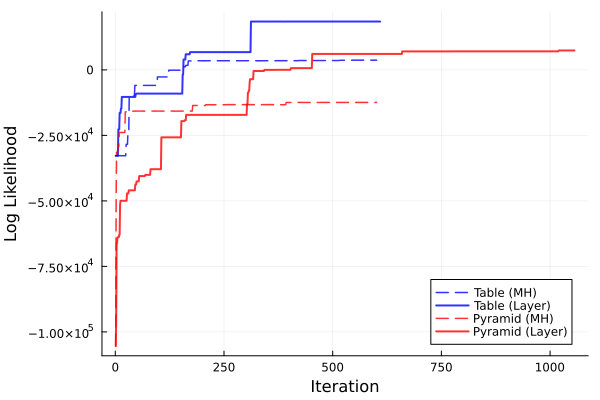

In [27]:
# After saving local variables of the two structures above, then run this cell for pairwise comparison

# Pack the data into a dictionary
# Format: "Label" => (MH_Traces, Layer_Traces)
comparison_data = Dict(
    "Table"   => (traces_mh_table, traces_lay_table),
    "Pyramid" => (traces_mh_pyramid, traces_lay_pyramid)
)
compare_likelihoods(comparison_data, filename="likelihood-mh_vs_layering")

# Layering (two views)

In [10]:
(obs_image_map, obs_bitmap, obs_bitmap_side, num_bricks, struct_name) = generate_table_ground_truth(two_views=true)
#(obs_image_map, obs_bitmap, obs_bitmap_side, num_bricks, struct_name) = generate_pyramid_ground_truth(two_views=true)

obs_bitmap

Generating 'Tall Table' ground truth (Two Views: true)...


PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [23]:
# layering method: two views
traces_lay2 = []

# make empty initial trace as a choicemap with zero bricks
constraints = Gen.choicemap()
constraints[:bricks_at_z => 1 => :num_bricks] = 0
combined_choices = merge(obs_image_map, constraints) # merge observations and constraints into one map

# make trace and push 
(trace, _) = Gen.generate(lego_layer_model, (WIDTH_VAL, DEPTH_VAL, MAX_HEIGHT_VAL, IMAGE_SIZE, true), combined_choices)
push!(traces_lay2, trace)

println("Initial trace score: $(get_score(trace))")

# Loop through each layers (in plate heights, 1 brick is 3 plate heights)
for z_stage in 1:MAX_HEIGHT_VAL
    # get valid connections
    (_, current_state) = view_layer_trace(trace, spp=1) 
    
    # 2. Check if there are valid connection points at this z-level
    valid_conns = get_connections_at_z(current_state, z_stage)
    
    if isempty(valid_conns)
        println("--- STAGE $(z_stage): No connections available. SKIPPING. ---")
        push!(traces_lay2, trace) # Keep the trace history consistent
        continue # skip this layer
    end

    println("--- STAGE $(z_stage): Found $(length(valid_conns)) connections ---")
    
    # mcmc layering loop
    for iter in 1:LAYER_ITERS

        # 20% chance to fix any layer below, and 80% focus on the current top layer
        z = z_stage
        if z_stage > 1 && rand() < 0.2
            z = rand(1:(z_stage - 1)) 
        end
        
        # Kernel 1: Add/Remove bricks
        (trace, _) = mh(trace, select(:bricks_at_z => z => :num_bricks))

        # Kernel 2: Mutate existing bricks
        choices = get_choices(trace) # brick count
        if has_value(choices, :bricks_at_z => z => :num_bricks)
             num_bricks_at_z = choices[:bricks_at_z => z => :num_bricks]
        else
             num_bricks_at_z = 0
        end
        
        if num_bricks_at_z > 0
            i = rand(1:num_bricks_at_z)
            
            # Mutate properties
            (trace, _) = mh(trace, select(:bricks_at_z => z => i => :conn_idx))
            (trace, _) = mh(trace, select(:bricks_at_z => z => i => :type))
            (trace, _) = mh(trace, select(:bricks_at_z => z => i => :orient))
        end
        push!(traces_lay2, trace)
    end
    
    score = get_score(trace)
    println("End of Stage $(z_stage), Score: $score")
end

println("Inference complete.")

Initial trace score: -65518.28195862238
--- STAGE 1: Found 64 connections ---
End of Stage 1, Score: -26990.23696021794
--- STAGE 2: No connections available. SKIPPING. ---
--- STAGE 3: No connections available. SKIPPING. ---
--- STAGE 4: Found 6 connections ---
End of Stage 4, Score: 4289.445246888398
--- STAGE 5: No connections available. SKIPPING. ---
--- STAGE 6: No connections available. SKIPPING. ---
--- STAGE 7: Found 4 connections ---
End of Stage 7, Score: 29554.01522926522
--- STAGE 8: Found 16 connections ---
End of Stage 8, Score: 33422.97471976379
--- STAGE 9: No connections available. SKIPPING. ---
--- STAGE 10: No connections available. SKIPPING. ---
--- STAGE 11: No connections available. SKIPPING. ---
--- STAGE 12: No connections available. SKIPPING. ---
Inference complete.


In [24]:
# plot the map estimate
best_trace_2v = traces_lay2[argmax(get_score.(traces_lay2))] 
best_choices_2v = get_choices(best_trace_2v) 

total_bricks_2v = count_total_bricks(best_choices_2v)
println("Best structure has $(total_bricks_2v) bricks")

(best_render_2v, best_state_2v) = view_layer_trace(best_trace_2v, rot_y = FIXED_GLOBAL_ROT_Y + 0.0, img_size=OUTPUT_IMG_SIZE)
best_render_2v

Best structure has 10 bricks


PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [25]:
(best_render_side, _) = view_layer_trace(best_trace_2v, rot_y = FIXED_GLOBAL_ROT_Y + 90.0, img_size=OUTPUT_IMG_SIZE)
best_render_side

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

In [26]:
# Likelihood Plot
likelihood_plot(traces_lay2, filename="layer_two_view/$(struct_name)-likelihood")

# MAP vs the ground truth
map_plot(traces_lay2, obs_bitmap, method=:layer, filename="layer_two_view/$(struct_name)-map_estimate")

# Expectation & Variance (chained)
chains_lay2 = run_multichain_inference(obs_image_map, method=:layer_two_view, n_chains=N_CHAINS)
expectation_variance_plot(chains_lay2, method=:layer, burn_in=20, step=TRACE_STEP, spp=16, filename="layer_two_view/$(struct_name)-expectation")

# gif
generate_gif(traces_lay2, method=:layer, filename="layer_two_view/$(struct_name)-animation", spp=OUTPUT_SPP, output_size=OUTPUT_IMG_SIZE, step=TRACE_STEP, show_plot=true)


Saved Likelihood Plot: outputs/layer_two_view/table-likelihood.png
Saved MAP Plot: outputs/layer_two_view/table-map_estimate.png
Starting Multichain Inference: layer_two_view (5 chains)...
  -> Chain 1 / 5
  -> Chain 2 / 5
  -> Chain 3 / 5
  -> Chain 4 / 5
  -> Chain 5 / 5
Processing 5 chains...
Total pooled samples: 1325


Rendering pooled samples... 100%|████████████████████████| Time: 0:01:37


Saved Visual Expectation Plot: outputs/layer_two_view/table-expectation.png
Generating GIF (layer, Plot: true)...
.
Saved: outputs/layer_two_view/table-animation.gif
